In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from nltk.tokenize import word_tokenize

import random

import re
import nltk

from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [113]:
df = pd.read_json("intents.json")



In [114]:
df_input = df.copy(deep= True)
df_input = pd.DataFrame(df_input['intents'].tolist(), index = df_input.index)
df_input.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."


In [115]:
df = pd.DataFrame(df['intents'].tolist(), index = df.index)

In [116]:
df.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."


In [117]:
df = df.explode('patterns').explode('responses')

In [118]:
df.head()

,tag,patterns,responses
0,greeting,Hi,Hello there. Tell me how are you feeling today?
0,greeting,Hi,Hi there. What brings you here today?
0,greeting,Hi,Hi there. How are you feeling today?
0,greeting,Hi,Great to see you. How do you feel currently?
0,greeting,Hi,Hello there. Glad to see you're back. What's g...


Unique Values and Counts in 'tag' column:
casual      66
greeting    60
about       48
default     40
sad         32
            ..
fact-28      1
fact-23      1
fact-16      1
fact-14      1
fact-24      1
Name: tag, Length: 80, dtype: int64


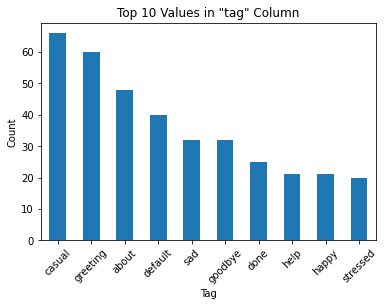

In [119]:
#plotting bar charts for unique values in tag column

unique_tags = df['tag'].unique()
unique_tag_counts = df['tag'].value_counts()
print("Unique Values and Counts in 'tag' column:")
print(unique_tag_counts)

top_n = 10 
unique_tag_counts.head(top_n).plot(kind='bar', rot=45) 
plt.title(f'Top {top_n} Values in "tag" Column')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()

In [120]:
df

,tag,patterns,responses
0,greeting,Hi,Hello there. Tell me how are you feeling today?
0,greeting,Hi,Hi there. What brings you here today?
0,greeting,Hi,Hi there. How are you feeling today?
0,greeting,Hi,Great to see you. How do you feel currently?
0,greeting,Hi,Hello there. Glad to see you're back. What's g...
...,...,...,...
76,fact-29,How do I know if I'm unwell?,"If your beliefs , thoughts , feelings or behav..."
77,fact-30,How can I maintain social connections? What if...,"A lot of people are alone right now, but we do..."
78,fact-31,What's the difference between anxiety and stress?,Stress and anxiety are often used interchangea...
79,fact-32,What's the difference between sadness and depr...,"Sadness is a normal reaction to a loss, disapp..."


In [121]:
#model fitting training and evaluation

max_seq_length = 30 #for padding 

# Tokenize patterns and responses
tokenizer_patterns = Tokenizer()
tokenizer_patterns.fit_on_texts(df['patterns'])
patterns_seq = tokenizer_patterns.texts_to_sequences(df['patterns'])
patterns_seq_padded = pad_sequences(patterns_seq, maxlen=max_seq_length, padding='post')

tokenizer_responses = Tokenizer()
tokenizer_responses.fit_on_texts(df['responses'])
responses_seq = tokenizer_responses.texts_to_sequences(df['responses'])
responses_seq_padded = pad_sequences(responses_seq, maxlen=max_seq_length, padding='post')

# Split the data into training and testing sets
X_train_patterns, X_test_patterns, y_train, y_test = train_test_split(patterns_seq_padded, df['tag'], test_size=0.2, random_state=42)
X_train_responses, X_test_responses = train_test_split(responses_seq_padded, test_size=0.2, random_state=42)

#Intent Prediction Model
intent_input = Input(shape=(max_seq_length,))
embedding_layer = Embedding(input_dim=len(tokenizer_patterns.word_index) + 1, output_dim=50)(intent_input)
bidirectional_lstm = Bidirectional(LSTM(64))(embedding_layer)
intent_output = Dense(units=len(set(df['tag'])), activation='softmax')(bidirectional_lstm)

intent_model = Model(inputs=intent_input, outputs=intent_output)
intent_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# label encoder to convert  y_train to numerical labels
label_encoder = LabelEncoder()
y_train_numerical_intent = label_encoder.fit_transform(y_train)

# One-hot encode y_train for intent model and reshaping it 
intent_labels_train = to_categorical(y_train_numerical_intent, num_classes=len(set(df['tag'])))
intent_labels_train = intent_labels_train.reshape(intent_labels_train.shape[0], intent_labels_train.shape[1])

# intent model fitting 
history_intent = intent_model.fit(X_train_patterns, intent_labels_train, epochs=10, batch_size=1, validation_split=0.2)

# response generation bidirectional lstm model
response_input = Input(shape=(max_seq_length,))
response_embedding_layer = Embedding(input_dim=len(tokenizer_responses.word_index) + 1, output_dim=50)(response_input)
bidirectional_lstm_response = Bidirectional(LSTM(64, return_sequences=True))(response_embedding_layer)
response_output = Dense(len(tokenizer_responses.word_index) + 1, activation='softmax')(bidirectional_lstm_response)

response_model = Model(inputs=response_input, outputs=response_output)
response_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#label encoding y_train
y_train_numerical_response = label_encoder.transform(y_train)

# One-hot encode y_train for response model
response_labels_train = to_categorical(responses_seq_padded, num_classes=len(tokenizer_responses.word_index) + 1)

print(X_train_responses.shape)
print(response_labels_train.shape)


# Fiting the response model
history_response = response_model.fit(X_train_responses, response_labels_train, epochs=10, batch_size=1, validation_split=0.2)



Epoch 1/10
422/422 [==============================] - 13s 12ms/step - loss: 3.7470 - accuracy: 0.1161 - val_loss: 3.4527 - val_accuracy: 0.1226
Epoch 2/10
422/422 [==============================] - 6s 14ms/step - loss: 2.9647 - accuracy: 0.2227 - val_loss: 2.8882 - val_accuracy: 0.2736
Epoch 3/10
422/422 [==============================] - 6s 14ms/step - loss: 2.2028 - accuracy: 0.4526 - val_loss: 2.3029 - val_accuracy: 0.4151
Epoch 4/10
422/422 [==============================] - 6s 13ms/step - loss: 1.5817 - accuracy: 0.6043 - val_loss: 1.7513 - val_accuracy: 0.6132
Epoch 5/10
422/422 [==============================] - 6s 14ms/step - loss: 1.0843 - accuracy: 0.7559 - val_loss: 1.3983 - val_accuracy: 0.7453
Epoch 6/10
422/422 [==============================] - 5s 13ms/step - loss: 0.8009 - accuracy: 0.8270 - val_loss: 1.1842 - val_accuracy: 0.7830
Epoch 7/10
422/422 [==============================] - 6s 15ms/step - loss: 0.6066 - accuracy: 0.8649 - val_loss: 1.0674 - val_accuracy: 0.820

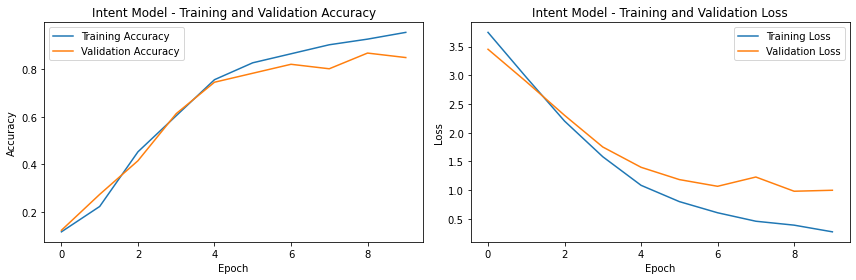

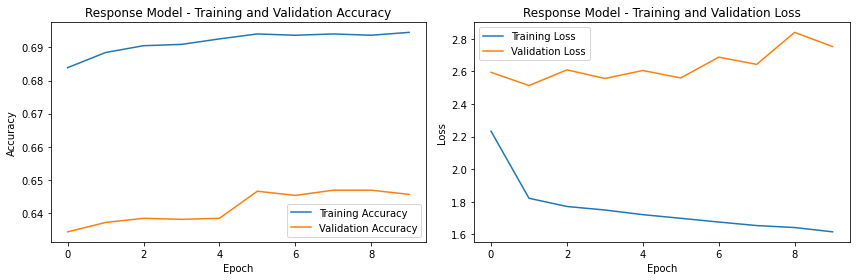

In [122]:
# Plotting Accuracy and Loss for Intent Model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_intent.history['accuracy'], label='Training Accuracy')
plt.plot(history_intent.history['val_accuracy'], label='Validation Accuracy')
plt.title('Intent Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_intent.history['loss'], label='Training Loss')
plt.plot(history_intent.history['val_loss'], label='Validation Loss')
plt.title('Intent Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting Accuracy and Loss for Response Model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_response.history['accuracy'], label='Training Accuracy')
plt.plot(history_response.history['val_accuracy'], label='Validation Accuracy')
plt.title('Response Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_response.history['loss'], label='Training Loss')
plt.plot(history_response.history['val_loss'], label='Validation Loss')
plt.title('Response Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [125]:
def get_random_response(tag):
    tag 
    tag_data = df_input[df_input['tag'] == tag]
    if not tag_data.empty:
        responses_list = tag_data['responses'].iloc[0]
        return random.choice(responses_list)
    else:
        return "Tag not found"

while True:
    new_sentence = str(input("Input Question: "))
    if new_sentence == "exit":
        break
    # Tokenize a new sentence for intent prediction
    new_sentence_seq = tokenizer_patterns.texts_to_sequences([new_sentence])
    new_sentence_padded = pad_sequences(new_sentence_seq, maxlen=max_seq_length, padding='post')

    # Predict the intent
    intent_prediction = intent_model.predict(new_sentence_padded)
    predicted_intent_index = np.argmax(intent_prediction)
    predicted_intent = label_encoder.classes_[predicted_intent_index]
    print(f"Predicted Mood: {predicted_intent}")

    # Tokenize the new sentence for response generation and predict the response 
    #this is not very accurate so instead we are using a random response model 
    #new_response_input = tokenizer_responses.texts_to_sequences([new_sentence])
    #new_response_input_padded = pad_sequences(new_response_input, maxlen=max_seq_length, padding='post')
    #response_prediction = response_model.predict(new_response_input_padded)
    #predicted_response_index = np.argmax(response_prediction, axis=-1)
    #predicted_response = " ".join([tokenizer_responses.index_word[i] for i in predicted_response_index[0] if i != 0])


    
    predicted_response = get_random_response(predicted_intent)
    print(f"Predicted Response: {predicted_response}")
    

Input Question: Hello
1/1 [==============================] - 0s 20ms/step
Predicted Mood: greeting
Predicted Response: Hi there. How are you feeling today?
Input Question: I am feeling well, how are you ?
1/1 [==============================] - 0s 23ms/step
Predicted Mood: hate-you
Predicted Response: Forgive me if i did anything to offend you. I only want to help
Input Question: yes i know
1/1 [==============================] - 0s 24ms/step
Predicted Mood: casual
Predicted Response: Can you elaborate on that?
Input Question: i feel like i dont want to live anymore
1/1 [==============================] - 0s 21ms/step
Predicted Mood: depressed
Predicted Response: Talk to me. Tell me more. It helps if you open up yourself to someone else.
Input Question: i dont think it will help
1/1 [==============================] - 0s 22ms/step
Predicted Mood: hate-you
Predicted Response: Forgive me if i did anything to offend you. I only want to help
Input Question: exit
